In [283]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost as xgb

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda

from sklearn import preprocessing

import os

from sklearn.linear_model import BayesianRidge, LinearRegression



In [166]:
def load_data(time_span=5):
    stop_events = feather.read_dataframe("../data_files/B/once/35days/stop_events_with_geo_train_test_averages.feather")
    stop_events = stop_events.set_index(stop_events.columns[0])
    
    stop_events[f"arrival_{time_span}mins"] = stop_events["actualArrival"].dt.round(f"{time_span} min")
    stop_events['offset_timestamp'] = stop_events[f"arrival_{time_span}mins"] - pd.Timedelta(f"{time_span} min")

    time_series = feather.read_dataframe(f"../data_files/B/once/35days/{time_span}mins/diff_percent_from_code_hour_day_-_full_segment_time_series.feather")
    time_series = time_series.set_index(time_series.columns[0])
    
#     time_series.columns = list(map(lambda x: x[:-2], time_series.columns))

    time_series = time_series.interpolate(
        method="time", axis=0
    )
    
    stop_events = filter_rare(stop_events)
    
    stop_events["arrival_5mins"] = stop_events["actualArrival"].dt.round("5min")
    stop_events["arrival_10mins"] = stop_events["actualArrival"].dt.round("10min")
    stop_events["arrival_60mins"] = stop_events["date"] + pd.to_timedelta(
        stop_events["arrival_hour"].values, unit="h"
    )
    
    return stop_events, time_series

def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events



In [167]:
se, ts = load_data(5)

Calculating rare segments...
	Calculated


In [169]:
# segments = se.groupby('segment_code')

In [372]:
def do_mape(actual_thing, predict):
    
    with np.errstate(divide='ignore', invalid='ignore'):

        division = (actual_thing[:,None] - predict)/actual_thing[:,None]

        division[actual_thing == 0, :] = 0

        mape = 100 / np.count_nonzero(actual_thing) * np.sum(np.abs(division), axis=0)

    return mape

def brute_force_mapes(stop_e, 
                      window=5,
                      thing="full_duration",
                      base="median_full_durations_by_segment_code_and_hour_and_day",
                      diff="diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day", 
                      absolute=False, speed=False, log=False):

    time_s = stop_e.pivot_table(
        index=f"arrival_{window}mins",
        columns="segment_code",
        values=diff,
        aggfunc=np.median,
    ).interpolate(
        method="time", axis=0
    )
    
    segments = stop_e.groupby('segment_code')

    best_preds = []
    best_code_pairs = []
    test_events_per_segement = []
#     bayesian_predict = []

    for segment_code, segment_events in tqdm(segments):
        
        # Train stage

        actual_thing = segment_events[segment_events['train']][thing].values

        actual_base = segment_events[segment_events['train']][base].values

        predict_array = time_s.loc[segment_events[segment_events['train']][f"arrival_{window}mins"].values]

        predict = actual_base[:,None] * (1+(predict_array/100))
        
        if(absolute):
            predict = actual_base[:,None] + predict_array
        else:
            predict = actual_base[:,None] * (1+(predict_array/100))
            
        if(speed):
            predict = segment_events.iloc[0,:]['line_distance']/predict
            
        if(log):
            predict = np.exp(predict)
            
        mape = do_mape(actual_thing, predict.values)
            
        best_columns = np.argsort(mape)
        
        best_code_pairs.append([segment_code, time_s.columns[best_columns[0]]])
        
#         clf = BayesianRidge()
        
#         clf.fit(predict.iloc[:, best_columns[:10]].replace(np.nan, 0), actual_thing)
        
        
        # Test stage
        
        actual_thing_test = segment_events[segment_events['test']][thing].values
        
        if(np.count_nonzero(actual_thing_test) == 0):
            best_preds.append([np.nan] * time_s.shape[1])
            test_events_per_segement.append(0)
#             bayesian_predict.append(0)
            continue 

        actual_base_test = segment_events[segment_events['test']][base].values

        predict_array_test = time_s.loc[segment_events[segment_events['test']][f"arrival_{window}mins"].values]
        
        if(absolute):
            predict_test = actual_base_test[:,None] + predict_array_test
        else:
            predict_test = actual_base_test[:,None] * (1+(predict_array_test/100))
            
        if(speed):
            predict_test = segment_events.iloc[0,:]['line_distance']/predict_test
        
        
        predict_test = predict_test.iloc[:,best_columns]
        
#         predict_bayesian_test = clf.predict(predict_test.iloc[:,best_columns[:10]].replace(np.nan, 0))
        
        if(log):
            predict_test = np.exp(predict_test)
#             predict_bayesian_test = np.exp(predict_bayesian_test)
        
        mape_test = do_mape(actual_thing_test, predict_test.values)
        
#         mape_bayes_test = do_mape(actual_thing_test, predict_bayesian_test[:,None])
        
        best_preds.append(mape_test)
        test_events_per_segement.append(actual_base_test.shape[0])
#         bayesian_predict.append(float(mape_bayes_test))
        
    best_preds = np.array(best_preds)
    best_code_pairs = np.array(best_code_pairs)
    test_events_per_segement = np.array(test_events_per_segement).squeeze()
#     bayesian_predict = np.array(bayesian_predict, dtype=float)
    
    total_test = np.count_nonzero(stop_e['test'])
    
    ma = np.ma.MaskedArray(best_preds, mask=np.isnan(best_preds))
    weighted_mapes = np.ma.average(ma, weights=test_events_per_segement, axis=0)
    
#     print(bayesian_predict.dtype, test_events_per_segement.dtype)
    
#     weighted_bayes_mape = np.average(bayesian_predict, weights=test_events_per_segement)
            
    plt.plot(weighted_mapes[:300])
    plt.title(f"Using {base}\nto predict {thing} with {window}min time windows")
    plt.show()
        
    return best_preds, weighted_mapes, # bayesian_predict, weighted_bayes_mape
            
    

In [350]:
a = np.array([1,2,3,4,5])

print(a.shape)

np.sum(a, axis=0)

(5,)


15

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http

float64 int64


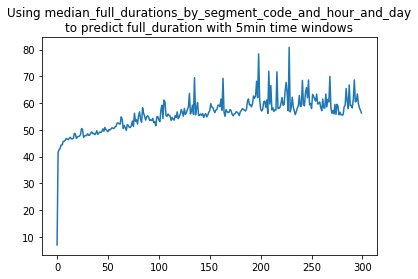

In [351]:
best_preds,weighted_mapes, b_pred, weighted_bayes_mape = brute_force_mapes(se);



In [360]:
weighted_bayes_mape

59.96668413125585

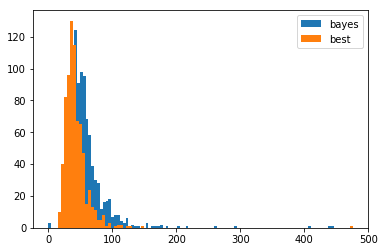

In [356]:
plt.hist(b_pred, bins=100, label="bayes")
plt.hist(best_preds[:,4], bins=100, label="best")
plt.legend()
plt.show()

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


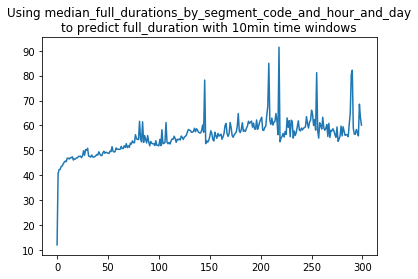

In [266]:
brute_force_mapes(se, window=10,
                      thing="full_duration",
                      base="median_full_durations_by_segment_code_and_hour_and_day",
                      diff="diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day");

In [267]:
se["diff_segment_and_median_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_median_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_median_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


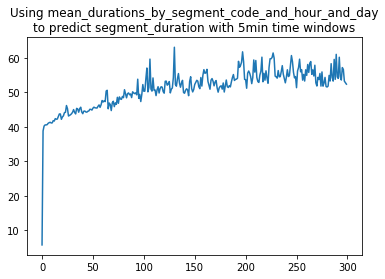

In [268]:
brute_force_mapes(se, window=5, 
                  thing="segment_duration", 
                  base="mean_durations_by_segment_code_and_hour_and_day", 
                  diff="diff_percent_segment_and_median_by_segment_code_and_hour_and_day");

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


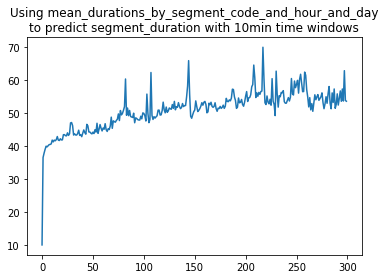

In [278]:
brute_force_mapes(se, window=10, 
                  thing="segment_duration", 
                  base="mean_durations_by_segment_code_and_hour_and_day", 
                  diff="diff_percent_segment_and_median_by_segment_code_and_hour_and_day");

In [269]:
se["diff_dwell_and_median_by_segment_code_and_hour_and_day"] = (
    se["dwell_duration_prev"]
    - se["median_dwell_prev_by_stop_code_and_hour_and_day"]
)

se["diff_percent_dwell_and_median_by_segment_code_and_hour_and_day"] = (
    se["diff_dwell_and_median_by_segment_code_and_hour_and_day"]
    * 100
    / se["median_dwell_prev_by_stop_code_and_hour_and_day"]
)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the f

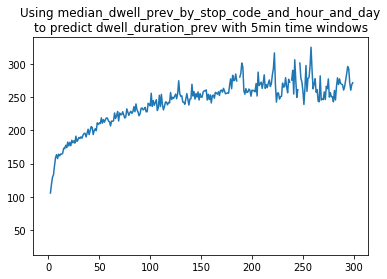

In [270]:
brute_force_mapes(se, window=5, 
                  thing="dwell_duration_prev", 
                  base="median_dwell_prev_by_stop_code_and_hour_and_day", 
                  diff="diff_percent_dwell_and_median_by_segment_code_and_hour_and_day");

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the f

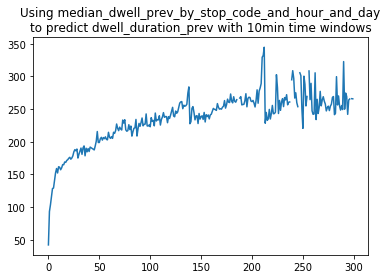

In [279]:
brute_force_mapes(se, window=10, 
                  thing="dwell_duration_prev", 
                  base="median_dwell_prev_by_stop_code_and_hour_and_day", 
                  diff="diff_percent_dwell_and_median_by_segment_code_and_hour_and_day");

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


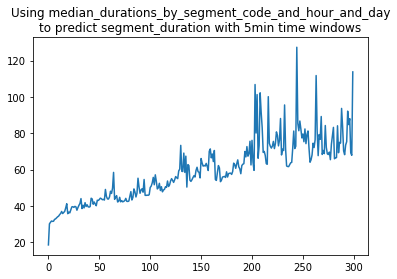

In [271]:
brute_force_mapes(se, window=5, 
                  thing="segment_duration", 
                  base="median_durations_by_segment_code_and_hour_and_day", 
                  diff="diff_segment_and_median_by_segment_code_and_hour_and_day", 
                  absolute=True);

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


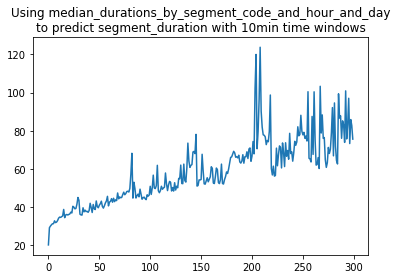

In [280]:
brute_force_mapes(se, window=10, 
                  thing="segment_duration", 
                  base="median_durations_by_segment_code_and_hour_and_day", 
                  diff="diff_segment_and_median_by_segment_code_and_hour_and_day", 
                  absolute=True);

In [273]:
se['speed'] = se['line_distance']/se['segment_duration']

segment_code_and_hour_and_day_groups = se[se["train"]].groupby(
        ["segment_code", "arrival_hour", "arrival_day"]
    )

median_speed_by_segment_code_and_hour_and_day = (
        segment_code_and_hour_and_day_groups["speed"]
        .median()
        .rename("median_speed_by_segment_code_and_hour_and_day")
    )
se = se.merge(
    median_speed_by_segment_code_and_hour_and_day.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "arrival_day"],
    right_index=True,
)

se["diff_speed_and_median_by_segment_code_and_hour_and_day"] = (
    se["speed"]
    - se["median_speed_by_segment_code_and_hour_and_day"]
)

se["diff_percent_speed_and_median_by_segment_code_and_hour_and_day"] = (
    se["diff_speed_and_median_by_segment_code_and_hour_and_day"]
    * 100
    / se["median_speed_by_segment_code_and_hour_and_day"]
)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in add
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in add
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


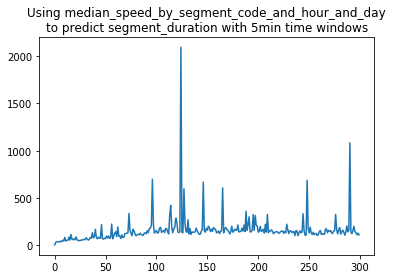

In [274]:
best_preds, best_code_pairs, test_events_per_segement, weighted_mapes = brute_force_mapes(se, window=5, 
                  thing="segment_duration", 
                  base="median_speed_by_segment_code_and_hour_and_day", 
                  diff="diff_speed_and_median_by_segment_code_and_hour_and_day", 
                  absolute=True, speed=True)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in add
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in add
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


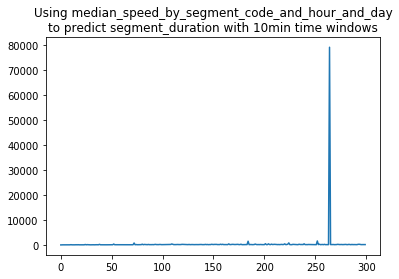

In [281]:
brute_force_mapes(se, window=10, 
                  thing="segment_duration", 
                  base="median_speed_by_segment_code_and_hour_and_day", 
                  diff="diff_speed_and_median_by_segment_code_and_hour_and_day", 
                  absolute=True, speed=True);

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


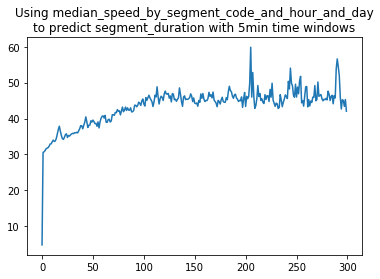

In [275]:
brute_force_mapes(se, window=5, 
                  thing="segment_duration", 
                  base="median_speed_by_segment_code_and_hour_and_day", 
                  diff="diff_percent_speed_and_median_by_segment_code_and_hour_and_day", 
                  absolute=False, speed=True);

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


float64 int64


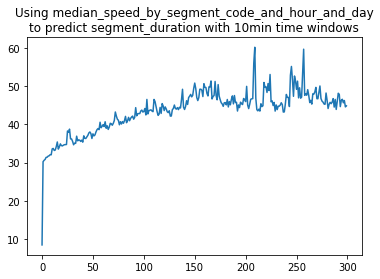

In [362]:
best_preds, weighted_mapes, bayesian_predict, weighted_bayes_mape = brute_force_mapes(se, window=10, 
                  thing="segment_duration", 
                  base="median_speed_by_segment_code_and_hour_and_day", 
                  diff="diff_percent_speed_and_median_by_segment_code_and_hour_and_day", 
                  absolute=False, speed=True);

In [366]:
se['log_seg_dur'] = np.log(se['segment_duration'])

segment_code_and_hour_and_day_groups = se[se["train"]].groupby(
        ["segment_code", "arrival_hour", "arrival_day"]
    )

median_log_dur_by_segment_code_and_hour_and_day = (
        segment_code_and_hour_and_day_groups["log_seg_dur"]
        .median()
        .rename("median_log_dur_by_segment_code_and_hour_and_day")
    )
se = se.merge(
    median_log_dur_by_segment_code_and_hour_and_day.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "arrival_day"],
    right_index=True,
)

se["diff_median_log_dur_by_segment_code_and_hour_and_day"] = (
    se["log_seg_dur"]
    - se["median_log_dur_by_segment_code_and_hour_and_day"]
)

se["diff_percent_median_log_dur_by_segment_code_and_hour_and_day"] = (
    se["diff_median_log_dur_by_segment_code_and_hour_and_day"]
    * 100
    / se["median_log_dur_by_segment_code_and_hour_and_day"]
)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in add
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in add
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


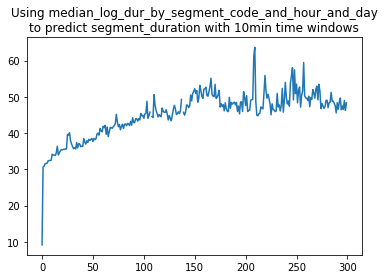

In [374]:
best_preds, weighted_mapes = brute_force_mapes(se, window=10, 
                  thing="segment_duration", 
                  base="median_log_dur_by_segment_code_and_hour_and_day", 
                  diff="diff_median_log_dur_by_segment_code_and_hour_and_day", 
                  absolute=True, speed=False, log=True);

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in multiply
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


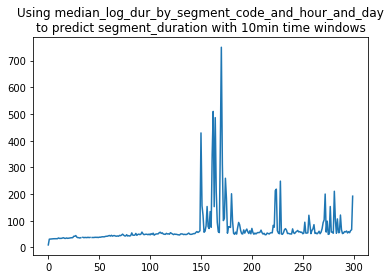

In [375]:
best_preds, weighted_mapes = brute_force_mapes(se, window=10, 
                  thing="segment_duration", 
                  base="median_log_dur_by_segment_code_and_hour_and_day", 
                  diff="diff_percent_median_log_dur_by_segment_code_and_hour_and_day", 
                  absolute=False, speed=False, log=True);

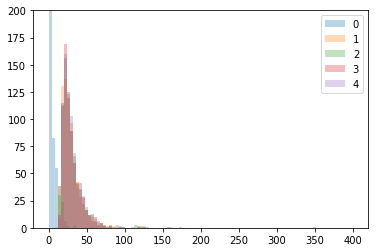

In [365]:
plt.hist(best_preds[:,0], bins=100, range=(0,400), alpha=0.3, label="0")
plt.hist(best_preds[:,1], bins=100, range=(0,400), alpha=0.3, label="1")
plt.hist(best_preds[:,2], bins=100, range=(0,400), alpha=0.3, label="2")
plt.hist(best_preds[:,3], bins=100, range=(0,400), alpha=0.3, label="3")
plt.hist(best_preds[:,4], bins=100, range=(0,400), alpha=0.3, label="4")
plt.legend()
plt.ylim((0,200))
plt.show()

In [ ]:
ma = np.ma.MaskedArray(best_preds, mask=np.isnan(best_preds))
weighted_mapes = np.ma.average(ma, weights=test_events_per_segement.squeeze(), axis=0)

In [ ]:
plt.plot(weighted_mapes[:10])
plt.ylim((0,100))
plt.show()